In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

%matplotlib inline

Загружаем датасет

In [2]:
links = pd.read_csv('/Users/irinanikulina/Documents/ML/RecommendationSystems/links.csv')
movies = pd.read_csv('/Users/irinanikulina/Documents/ML/RecommendationSystems/movies.csv')
ratings = pd.read_csv('/Users/irinanikulina/Documents/ML/RecommendationSystems/ratings.csv')
tags = pd.read_csv('/Users/irinanikulina/Documents/ML/RecommendationSystems/tags.csv')

In [3]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
# Создание нового датафрейма для работы
movies_with_ratings = movies.join(ratings.set_index('movieId'), on='movieId').reset_index(drop=True)
movies_with_ratings.dropna(inplace=True)

In [8]:
movies_with_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15.0,2.5,1.510578e+09
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17.0,4.5,1.305696e+09


In [9]:
def change_string(s):
    return' '.join(s.replace(' ','').replace('-','').split('|'))

In [10]:
movie_genres = [change_string(g) for g in movies_with_ratings.genres.values]

Построим рекомендации (регрессия, предсказываем оценку) на TF-IDF по жанрам

In [11]:
movie_genres

['Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fantasy',
 'Adventure Animation Children Comedy Fa

In [12]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(movie_genres)

In [13]:
count_vect.get_feature_names()

['action',
 'adventure',
 'animation',
 'children',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'fantasy',
 'filmnoir',
 'horror',
 'imax',
 'musical',
 'mystery',
 'nogenreslisted',
 'romance',
 'scifi',
 'thriller',
 'war',
 'western']

In [14]:
print(X_train_counts.shape)

(100836, 20)


In [15]:
X = X_train_counts.toarray()

In [16]:
y = movies_with_ratings.rating

In [17]:
X_tr, X_ts, y_tr, y_ts = train_test_split(X_train_counts.toarray(),y,test_size = 0.15)

In [18]:
knr = KNeighborsRegressor(n_neighbors=15,n_jobs = -1, metric = 'euclidean')

In [19]:
knr.fit(X_tr, y_tr)

KNeighborsRegressor(metric='euclidean', n_jobs=-1, n_neighbors=15)

In [20]:
knr.predict(X_ts)

array([3.3       , 3.33333333, 4.3       , ..., 2.86666667, 3.76666667,
       3.9       ])

In [21]:
knr.score(X_tr,y_tr)

0.036363906151951064

In [22]:
scores = cross_val_score(knr, X, y, cv=5, verbose=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.1s finished


In [23]:
print(scores)

[-0.21066185 -0.15851144 -0.07452149 -0.14748643 -0.13581015]


In [24]:
tfidf_transformer = TfidfTransformer()

In [25]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [26]:
print(X_train_tfidf.toarray())

[[0.         0.36388502 0.54973521 ... 0.         0.         0.        ]
 [0.         0.36388502 0.54973521 ... 0.         0.         0.        ]
 [0.         0.36388502 0.54973521 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.51274474 0.         0.85854111 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [27]:
neigh = NearestNeighbors(n_neighbors = 7, n_jobs = -1, metric = 'euclidean')
neigh.fit(X_train_tfidf)

NearestNeighbors(metric='euclidean', n_jobs=-1, n_neighbors=7)

In [28]:
test = change_string("Comedy|Drama|Romance")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [29]:
res

(array([[0., 0., 0., 0., 0., 0., 0.]]),
 array([[61012, 61011, 61014, 61013, 61016, 61010, 61017]]))

In [30]:
movies_with_ratings.iloc[res[1][0]]

,movieId,title,genres,userId,rating,timestamp
61017,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,453.0,5.0,1.005966e+09
61016,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,418.0,0.5,1.461868e+09
61019,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,479.0,4.0,1.039367e+09
61018,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,474.0,4.5,1.053021e+09
61021,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,483.0,4.0,1.327277e+09
61015,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,414.0,4.0,1.073682e+09
61022,4246,Bridget Jones's Diary (2001),Comedy|Drama|Romance,489.0,5.0,1.332773e+09


Построим рекомендации (регрессия, предсказываем оценку) на TF-IDF по тегам

In [31]:
movies_with_tags = movies.join(tags.set_index('movieId'), on='movieId')

In [32]:
movies_with_tags.head()

,movieId,title,genres,userId,tag,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,336.0,pixar,1.139046e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,474.0,pixar,1.137207e+09
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,567.0,fun,1.525286e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09


In [33]:
movies_with_tags[movies_with_tags.title == 'Jumanji (1995)']

,movieId,title,genres,userId,tag,timestamp
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,fantasy,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,magic board game,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,62.0,Robin Williams,1.528844e+09
1,2,Jumanji (1995),Adventure|Children|Fantasy,474.0,game,1.137376e+09


In [34]:
movies_with_tags.tag.unique()

array(['pixar', 'fun', 'fantasy', ..., 'star wars', 'gintama', 'remaster'],
      dtype=object)

In [35]:
movies_with_tags.tag.unique().shape

(1590,)

In [36]:
movies_with_tags.dropna(inplace=True)

In [37]:
movies_with_tags.title.unique().shape

(1572,)

In [38]:
tag_strings = []
movies = []

for movie, group in tqdm(movies_with_tags.groupby('title')):
    tag_strings.append(' '.join([str(s).replace(' ', '').replace('-', '') for s in group.tag.values]))
    movies.append(movie)

In [39]:
tag_strings[:15]

['artistic Funny humorous inspiring intelligent quirky romance ZooeyDeschanel',
 'lawyers',
 'creepy suspense',
 'Shakespearesortof',
 'dogs remake',
 'Disney',
 'terrorism',
 'court claustrophobic confrontational earnest gooddialogue greatscreenplay gritty Motivational thoughtprovoking',
 'stranded',
 'MarkRuffalo',
 'Hal space aliens apes ArthurC.Clarke artificialintelligence atmospheric cinematography classic computer confusingending cultfilm Dull future futuristic imdbtop250 masterpiece meditative music mystery Oscar(BestEffectsVisualEffects) overrated philosophical relaxing revolutionary robots scifi setting:space/spaceship slow slowpaced soundtrack space spacetravel spacecraft StanleyKubrick superbsoundtrack surreal technology tedious visual visuallyappealing',
 'DEPRESSING',
 'crime nightclub',
 'zombies zombies',
 'fugitive']

In [40]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(tag_strings)

In [41]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [42]:
neigh = NearestNeighbors(n_neighbors=10, n_jobs=-1, metric='manhattan') 
neigh.fit(X_train_tfidf)

NearestNeighbors(metric='manhattan', n_jobs=-1, n_neighbors=10)

In [43]:
for i in range(len(movies)):
    if 'Jumanji (1995)' == movies[i]:
        print(i)

712


In [44]:
tag_strings[712]

'fantasy magicboardgame RobinWilliams game'

In [45]:
test = change_string("lawyers")

predict = count_vect.transform([test])
X_tfidf2 = tfidf_transformer.transform(predict)

res = neigh.kneighbors(X_tfidf2, return_distance=True)

In [46]:
res

(array([[0., 0., 0., 0., 0., 1., 1., 2., 2., 2.]]),
 array([[   1,  770, 1034, 1376,  771,  661,  822,  951,  949,  953]]))

In [47]:
for i in res[1][0]:
    print(movies[i])

...And Justice for All (1979)
Legal Eagles (1986)
Pelican Brief, The (1993)
The Devil's Advocate (1997)
Legally Blonde (2001)
In a Lonely Place (1950)
Magnolia (1999)
Never Been Kissed (1999)
Net, The (1995)
Niagara (1953)


Рассчитаем средние оценки (+ median, variance, etc.) фильма

<AxesSubplot:>

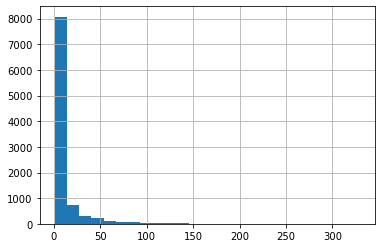

In [48]:
# Гистограмма количества оценок рейтинга. Более 8000 фильмов имеют от 0 до 10 оценок. 
# Только 200 фильмов имеют 50 оценок.
ratings.groupby('movieId').rating.count().hist(bins=25)

In [49]:
# Медиана оценок на фильм
ratings.groupby('movieId').rating.count().median()

3.0

In [50]:
# Среднее количество (математическое ожидание) оценок на фильм
ratings.groupby('movieId').rating.count().mean()

10.369806663924312

In [51]:
# Средняя оценка фильма по его id
movieID_mean = ratings.groupby('movieId').rating.mean()
movieID_mean

movieId
1         3.920930
2         3.431818
3         3.259615
4         2.357143
5         3.071429
            ...   
193581    4.000000
193583    3.500000
193585    3.500000
193587    3.500000
193609    4.000000
Name: rating, Length: 9724, dtype: float64

In [52]:
# Средняя оценка по всем фильмам
np.mean(movieID_mean)

3.2624482748109656

In [53]:
# Дисперсия оценок по всем фильмам
np.var(movieID_mean)

0.7566023242488846

Рассчитаем средние оценки (+ median, variance, etc.) пользователя

<AxesSubplot:>

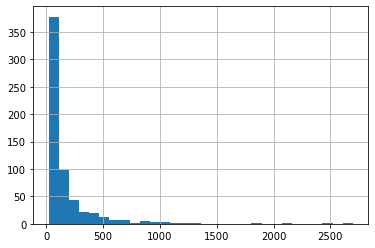

In [54]:
# Гистограмма количества оценок на пользователя. Более 360 пользователей поставили от 0 до 10 оценок. 
# 10 пользователей поставили от 490 до 510 оценок.
ratings.groupby('userId').rating.count().hist(bins=30)

In [55]:
# Медиана оценок на пользователя
ratings.groupby('userId').rating.count().median()

70.5

In [56]:
# Среднее количество (математическое ожидание) оценок на пользователя
ratings.groupby('userId').rating.count().mean()

165.30491803278687

In [57]:
# Средняя оценка фильма пользователем
userID_mean = ratings.groupby('userId').rating.mean()
userID_mean

userId
1      4.366379
2      3.948276
3      2.435897
4      3.555556
5      3.636364
         ...   
606    3.657399
607    3.786096
608    3.134176
609    3.270270
610    3.688556
Name: rating, Length: 610, dtype: float64

In [58]:
# Средняя оценка по всем пользователям
np.mean(userID_mean)

3.657222337747402

In [59]:
# Дисперсия оценок по всем пользователям
np.var(userID_mean)

0.2306316028462928